In [ ]:
!pip3 install numpy
!pip3 install pandas
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install pillow
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tensorflow-metal
!pip3 install wordcloud

In [39]:
import os, pickle, warnings,re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from wordcloud import WordCloud, STOPWORDS


warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# Introduction and Problem Description

This project addresses the Kaggle challenge "Natural Language Processing with Disaster Tweets," where the goal is to classify tweets as either related to real disasters (1) or not (0). The dataset contains short tweets and corresponding binary labels. We approach the problem using Recurrent Neural Networks (RNNs), starting with a baseline model using a simple RNN layer.

In [47]:
train = pd.read_csv("files/train.csv")
test = pd.read_csv("files/test.csv")

# EDA / Data Wrangling
Here are some of the early steps I took to clean, pre-process, and explore the provided data sets.
1. Form a word cloud on the raw text to get a sense of any weird high level issues.
2. Saw single character and url related keywords in the most common words.
3. Remove stop words and convert all text to lower case in preparation for tokenization.
4. Review distributions of the positive/negative values in the training set.

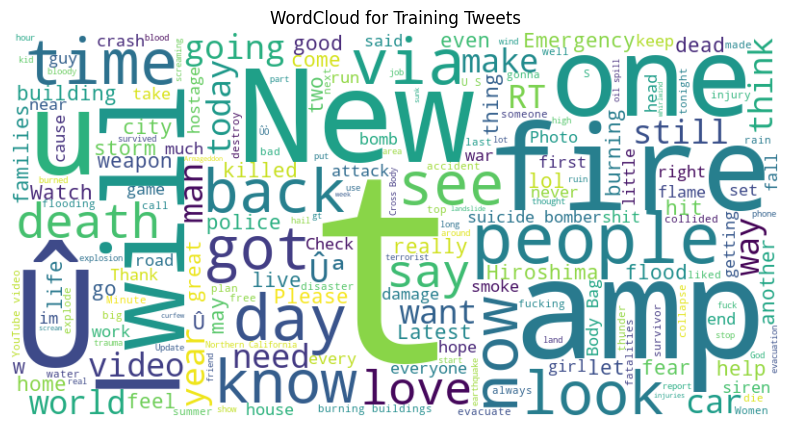

In [48]:
# Word Cloud
text = " ".join(train["text"])
wc = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for Training Tweets")
plt.show()

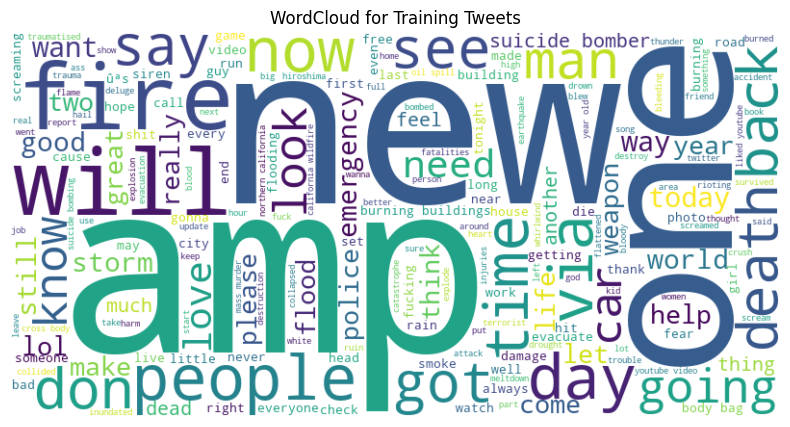

In [27]:
STOPWORDS.update(["https", "co"])

train["text_cleaned"] = train["text"].apply(
    lambda x: " ".join(
        word.lower()
        for word in re.findall(r"\b\w+\b", x)
        if word.lower() not in STOPWORDS and len(word) > 2
    )
)
text = " ".join(train["text_cleaned"])
wc = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for Training Tweets")
plt.show()


#Also do the same cleaning to the test set
test["text_cleaned"] = test["text"].apply(
    lambda x: " ".join(
        word.lower()
        for word in re.findall(r"\b\w+\b", x)
        if word.lower() not in STOPWORDS and len(word) > 2
    )
)

In [ ]:
print("Training Set Shape = {}".format(train.shape))
print("Training Set Memory Usage = {:.2f} MB".format(train.memory_usage().sum() / 1024**2))
tweet_lengths = train["text_cleaned"].apply(lambda x: len(x.split()))
print("Training Text Lengths: ", tweet_lengths.describe())
print("Test Set Shape = {}".format(test.shape))
print("Test Set Memory Usage = {:.2f} MB".format(test.memory_usage().sum() / 1024**2))
tweet_lengths = test["text_cleaned"].apply(lambda x: len(x.split()))
print("Test Text Lengths: ", tweet_lengths.describe())



train.head()

Training Set Shape = (7613, 6)
Training Set Memory Usage = 0.35 MB
Training Text Lengths:  count    7613.000000
mean        9.497307
std         3.529680
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: text_cleaned, dtype: float64
Test Set Shape = (3263, 5)
Test Set Memory Usage = 0.12 MB
Test Text Lengths:  count    3263.000000
mean        9.622740
std         3.581006
min         0.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: text_cleaned, dtype: float64


,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,000 people receive wildfires evacuation orders...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


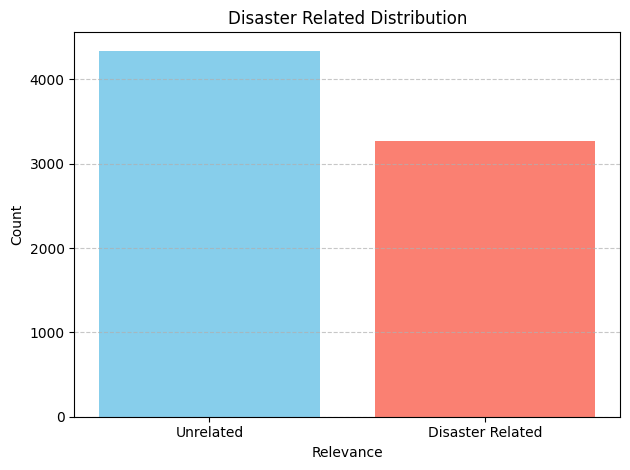

In [45]:
# Distributions


negative_ids,positive_ids = train[train["target"] == 0]["id"], train[train["target"] == 1]["id"]
counts = [len(negative_ids), len(positive_ids)]

# Labels for the bars
labels = ["Unrelated", "Disaster Related"]
plt.bar(
    labels,
    counts,
    color=["skyblue", "salmon"]
)
plt.title("Disaster Related Distribution")
plt.xlabel("Relevance")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Modeling / Architecture
This setup builds and evaluates four RNN-based models to classify tweets as disaster-related or not, using the Kaggle competition dataset. The text is tokenized and padded to a fixed length of 22 words, based on the observed maximum in the dataset. We use a SimpleRNN architecture for interpretability and baseline performance, paired with an Embedding layer to learn dense word representations. Each model varies in its hyperparameters, such as the number of RNN units, embedding dimension, dropout rate, and batch size, allowing comparison across configurations. The goal is to find a balance between model complexity and generalization. Training performance is assessed using loss, accuracy, and a confusion matrix, while predictions on the test set are exported for Kaggle submission. This systematic variation supports early-stage benchmarking before moving to more complex architectures like LSTM or GRU.


=== Model 1 ===


2025-06-01 17:32:53.977276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-01 17:38:58.240798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Final Training Loss: 0.0585, Accuracy: 0.9771
  5/238 [..............................] - ETA: 6s

2025-06-01 17:39:05.128322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 7s 28ms/step
Confusion Matrix:
 [[4272   70]
 [ 104 3167]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4342
           1       0.98      0.97      0.97      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613

102/102 [==============================] - 3s 27ms/step


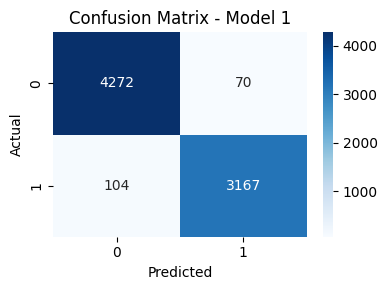


=== Model 2 ===


2025-06-01 17:39:15.148373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-01 17:42:56.745896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Final Training Loss: 0.0465, Accuracy: 0.9812
  5/238 [..............................] - ETA: 6s

2025-06-01 17:43:03.682728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 7s 27ms/step
Confusion Matrix:
 [[4292   50]
 [  93 3178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4342
           1       0.98      0.97      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613

102/102 [==============================] - 3s 31ms/step


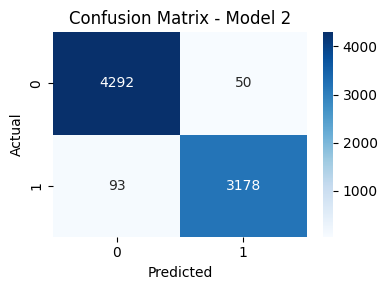


=== Model 3 ===


2025-06-01 17:43:14.963533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-01 17:45:34.667568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Final Training Loss: 0.0457, Accuracy: 0.9802
  5/238 [..............................] - ETA: 6s

2025-06-01 17:45:41.647774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 7s 28ms/step
Confusion Matrix:
 [[4287   55]
 [  96 3175]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4342
           1       0.98      0.97      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613

102/102 [==============================] - 3s 29ms/step


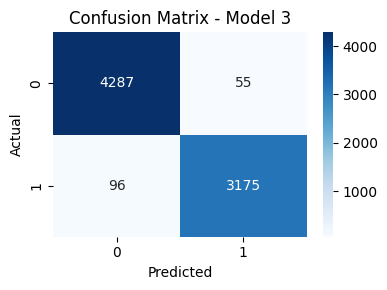


=== Model 4 ===


2025-06-01 17:45:51.788712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-01 17:58:33.399795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Final Training Loss: 0.0385, Accuracy: 0.9824
  5/238 [..............................] - ETA: 6s

2025-06-01 17:58:40.501321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 7s 27ms/step
Confusion Matrix:
 [[4290   52]
 [  82 3189]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4342
           1       0.98      0.97      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613

102/102 [==============================] - 3s 27ms/step


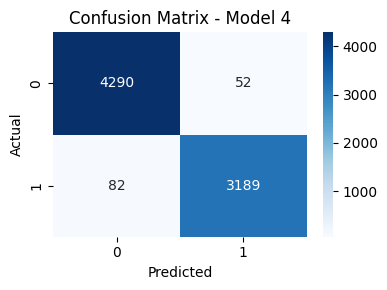

In [41]:
# Parameters
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 22

# Prepare tokenizer and pad sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train["text_cleaned"])

X_train = tokenizer.texts_to_sequences(train["text_cleaned"])
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = tokenizer.texts_to_sequences(test["text_cleaned"])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
y_train = train["target"].values

# Define model configurations
model_configs = [
    {"rnn_units": 32, "embedding_dim": 32, "dropout": 0.0, "epochs": 5, "batch_size": 32, "file": "files/model1.keras"},
    {"rnn_units": 64, "embedding_dim": 64, "dropout": 0.2, "epochs": 6, "batch_size": 64, "file": "files/model2.keras"},
    {"rnn_units": 128, "embedding_dim": 128, "dropout": 0.3, "epochs": 7, "batch_size": 128, "file": "files/model3.keras"},
    {"rnn_units": 64, "embedding_dim": 64, "dropout": 0.5, "epochs": 10, "batch_size": 32, "file": "files/model4.keras"},
]

os.makedirs("files", exist_ok=True)

# Train and evaluate each model
for i, cfg in enumerate(model_configs):
    print(f"\n=== Model {i+1} ===")
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=cfg["embedding_dim"], input_length=MAX_SEQUENCE_LENGTH))
    model.add(SimpleRNN(cfg["rnn_units"]))
    if cfg["dropout"] > 0:
        model.add(Dropout(cfg["dropout"]))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=cfg["epochs"], batch_size=cfg["batch_size"], verbose=0)

    loss, acc = model.evaluate(X_train, y_train, verbose=0)
    print(f"Final Training Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    preds = (model.predict(X_train) > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_train, preds)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_train, preds))
    
    test["target"] = (model.predict(X_test) > 0.5).astype(int).flatten()
    test[["id", "target"]].to_csv(f"files/kaggle_output_{i}.csv", index=False)

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Model {i+1}")
    plt.tight_layout()
    plt.show()

    # Save model
    model.save(cfg["file"])

# Results / Analysis
| Model | Accuracy   | Loss       | False Positives | False Negatives |
| ----- | ---------- | ---------- | --------------- | --------------- |
| 1     | 0.9771     | 0.0585     | 70              | 104             |
| 2     | 0.9802     | 0.0465     | 50              | 93              |
| 3     | 0.9802     | 0.0457     | 55              | 96              |
| 4     | **0.9824** | **0.0385** | **52**          | **82**          |

* All models perform very similarly with precision, recall, and F1-scores around 0.98.
* Model 4 edges out others with the lowest loss (0.0385) and highest accuracy (0.9824).
* It also has the lowest number of false negatives (82), which is important in disaster detection where missing real cases is riskier than false alarms.
* From just the training set, model 4 appears to be the strongest.
* When submitting to Kaggle for scoring, all were within a few points of each other but model 2 (output_1) had the highest with 0.75 suggesting model 4 might be a bit overfit. Model 2 seems like the best of this group. 

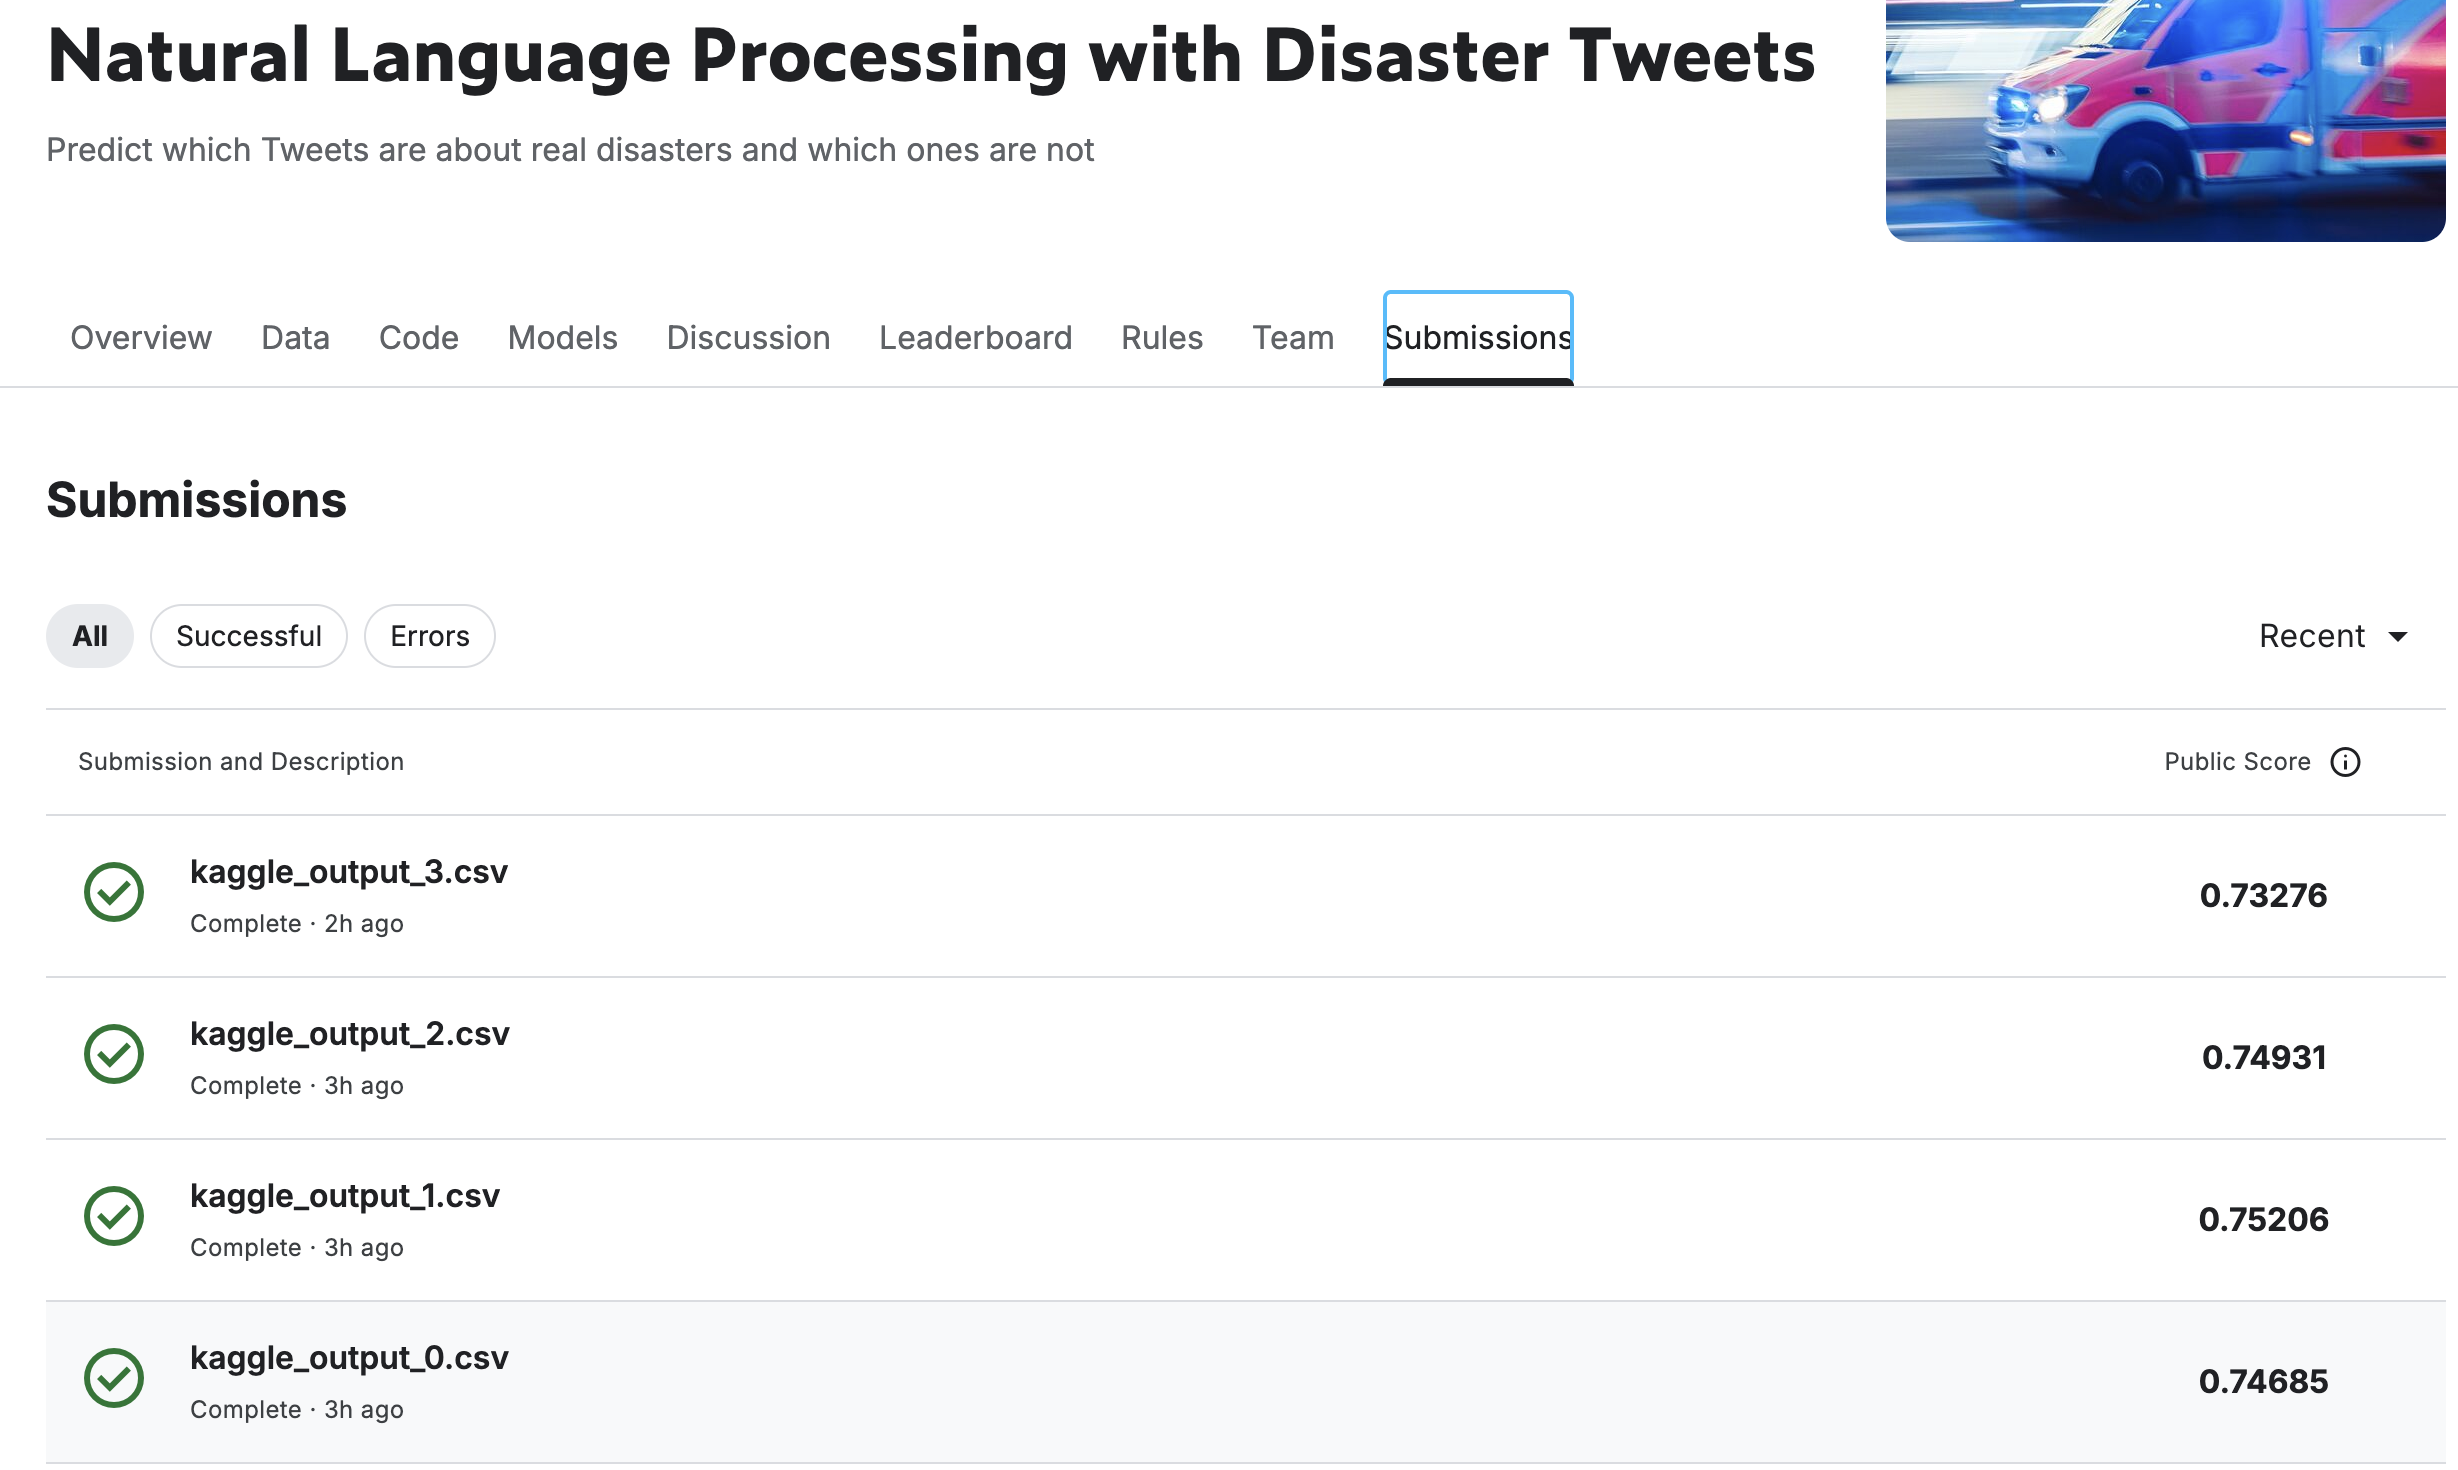

# Conclusion
After building and evaluating four RNN models with varying hyperparameters, all models performed similarly on training data with high accuracy and balanced classification metrics. While Model 4 initially appeared to be the strongest based on training metrics alone, external validation on unseen data revealed that Model 2 generalized better. This highlights the importance of validating beyond the training set to avoid overfitting. Simple RNNs, even with modest tuning, proved effective for this binary tweet classification task. Model 2 stands out as the most reliable for real-world deployment in this context.